In [1]:
from requests import get
import xml.etree.ElementTree as etree
from zeep import Client
import time
import datetime
from datetime import timedelta
import calendar
import pprint
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings('ignore')

### Задание №1

Запросить курсы любой валюты за последний год. Сохранить полученные данные в базу данных Mongo

In [2]:
def parse_currency(url, currency, period_range):
    currency_frame = pd.DataFrame(columns=['Currency', 'Date', 'Kurs'])
    client = Client(url)
    
    i=0
    for day in period_range:
        curs_date = client.service.GetCursOnDate(str(day))
        curs_list = curs_date._value_1._value_1
        
        for item in curs_list:
            for k,v in item.items():
                if v.VchCode == currency:
                    currency_frame.loc[i] = [v.Vname, str(day), float(v.Vcurs)]
                i+=1
    return currency_frame

In [3]:
currency = 'EUR'
url = "https://www.cbr.ru/DailyInfoWebServ/DailyInfo.asmx?WSDL"

In [4]:
start_period = input('Введите начальную дату в формате mm/dd/YYYY  ')

Введите начальную дату в формате mm/dd/YYYY  01/12/2017


In [5]:
end_period = input('Введите конечную дату в формате mm/dd/YYYY  ')

Введите конечную дату в формате mm/dd/YYYY  01/12/2018


In [6]:
period_range = pd.period_range(start=start_period, end=end_period)

In [7]:
currency_frame = parse_currency(url, currency, period_range)

Forcing soap:address location to HTTPS
Forcing soap:address location to HTTPS


In [8]:
currency_frame.head()

,Currency,Date,Kurs
10,Евро ...,2017-01-12,63.5184
43,Евро ...,2017-01-13,63.2759
76,Евро ...,2017-01-14,63.1222
109,Евро ...,2017-01-15,63.1222
142,Евро ...,2017-01-16,63.1222


После того как получили курсы валюты и вывели их на экран, теперь сохраним их в MongoDB

In [9]:
client = MongoClient('mongodb://127.0.0.1:27017')
db = client['currency']
currencydb = db.currency

In [10]:
for index, row in currency_frame.iterrows():
    currency_data={
        'Currency': row['Currency'],
        'Date': row['Date'],
        'Kurs': row['Kurs']
    }
    currencydb.insert(currency_data)

In [11]:
currencydb

Collection(Database(MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True), 'currency'), 'currency')

### Задание №2 и 3

Написать функцию, которая принимает в качестве параметров две даты, ищет самую большую разницу между курсами валюты за указанный период и возвращает эти дни.

Сделать вывод информативным: Валюту <Валюта> выгодно было купить <Дата>, а продать <Дата>. Прибыль: <Разница в цене валюты>

In [12]:
def biggest_difference_courses(url, currency, period_range):
    client = Client(url)
    min_curs = 10000000
    max_curs = 0
    curs_dict = {}
    
    for day in period_range:
        curs = client.service.GetCursOnDate(str(day))
        curs_list = curs._value_1._value_1
        for item in curs_list:
            for k,v in item.items():
                if v.VchCode == currency:
                    curs_dict[str(day)] = float(v.Vcurs)
                    if float(v.Vcurs) < min_curs:
                        min_curs = float(v.Vcurs)
                        min_day = str(day)
                    if float(v.Vcurs) > max_curs:
                        max_curs = float(v.Vcurs)
                        max_day = str(day)
                        
    curses = pd.Series(curs_dict)
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(curses)
    ax.set(title='Динамика курса валюты', xlabel='Дата', ylabel='Цена')
    ax.annotate('Покупаем', xy=(min_day, min_curs))
    ax.annotate('Продаем', xy=(max_day, max_curs))
    
    result = f'Валюту {currency} выгодно было купить {min_day} по курсу {min_curs} рублей, а продать {max_day} по курсу {max_curs}, разница составила {round(max_curs - min_curs, 4)} рублей'
    return result

Forcing soap:address location to HTTPS
Forcing soap:address location to HTTPS


'Валюту EUR выгодно было купить 2017-04-19 по курсу 59.6124 рублей, а продать 2017-08-04 по курсу 71.9527, разница составила 12.3403 рублей'

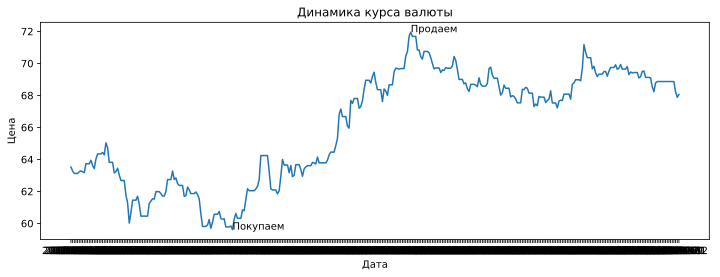

In [13]:
biggest_difference_courses(url, currency, period_range)